<center> <h1>Kim's CNN for Sentiment Analysis using Keras   </h1></cernter>
<hl>

---



**Anoop K. & Manjary P. Gangan** <br>
CIDA Labs, Department of Computer Science<br>
University of Calicut<br>
https://dcs.uoc.ac.in/~anoop <br>
https://dcs.uoc.ac.in/~manjary <br><br>
________________________

<center><img width="550" height="250" src="https://drive.google.com/uc?id=1TD138tj4cb89_3E62wqsvqR9WUiwNDx_"></center>

# Sentiment Analysis: Predict Sentiment from Movie Reviews with Kim's Model
<div style="text-align: justify">Definition 1: Sentiment analysis (also known as opinion mining or emotion AI) refers to the use of natural language processing, text analysis, computational linguistics, and biometrics to systematically identify, extract, quantify, and study affective states and subjective information. Sentiment analysis is widely applied to voice of the customer materials such as reviews and survey responses, online and social media, and healthcare materials for applications that range from marketing to customer service to clinical medicine. </div> <br>
<div style="text-align: justify"> Definition 2: Sentiment analysis is a type of data mining that measures the inclination of people’s opinions through natural language processing (NLP), computational linguistics and text analysis, which are used to extract and analyze subjective information from the Web - mostly social media and similar sources. The analyzed data quantifies the general public's sentiments or reactions toward certain products, people or ideas and reveal the contextual polarity of the information.</div>

<center><img width="800" height="600" src="https://drive.google.com/uc?id=1Q90KCeWdyB2vACz2z9rQR27nssYO7Hxi"></center>

# Text to Vector
  > ### 1. TF-IDF
  > ### 2. One-Hot encoding
  > ### 3. Word Embedding

# IMDB Movie Review Sentiment Problem Description
## Dataset Description : Large Movie Review Dataset v1.0
<div style="text-align: justify">The Large Movie Review Dataset (often referred to as the IMDB dataset) contains 25,000 highly polar moving reviews (good or bad) for training and the same amount again for testing. The problem is to determine whether a given moving review has a positive or negative sentiment.
The data was collected by Stanford researchers and was used in a 2011 paper <a href="http://ai.stanford.edu/~amaas/papers/wvSent_acl2011.pdf"> [PDF] </a>where a split of 50/50 of the data was used for training and test. An accuracy of 88.89% was achieved.
The data was also used as the basis for a Kaggle competition titled “Bag of Words Meets Bags of Popcorn” in late 2014 to early 2015. Accuracy was achieved above 97% with winners achieving 99%.</div>


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import glob
import string
import gensim as gs
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize, RegexpTokenizer
import numpy as np
import matplotlib.pyplot as plt

from gensim import utils
from gensim.models.doc2vec import LabeledSentence
from gensim.models import Doc2Vec

from sklearn.cluster import KMeans
from itertools import repeat

from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
#from keras.utils import to_categorical
from tensorflow.keras.utils import to_categorical

import gensim
from gensim.models import Word2Vec
from gensim.utils import simple_preprocess

from gensim.models.keyedvectors import KeyedVectors

from keras.layers import Embedding
from keras.layers import Dense, Input, GlobalMaxPooling1D
from keras.layers import Conv1D, MaxPooling1D, Embedding
from keras.models import Model
from keras.layers import Input, Dense, Embedding, Conv2D, MaxPooling2D, Dropout,concatenate
from keras.layers.core import Reshape, Flatten
from keras.callbacks import EarlyStopping
#from keras.optimizers import Adam
from tensorflow.keras.optimizers import Adam
from keras.models import Model
from keras import regularizers
from keras.callbacks import ModelCheckpoint



```
# This is formatted as code
```

## Load the IMDB Dataset from Text File
<div style="text-align: justify">
   The core dataset contains 50,000 reviews split evenly into 25k train and 25k test sets. The overall istribution of labels is balanced (25k pos and 25k neg). We also include an additional 50,000 unlabeled documents for unsupervised learning. But for this sample <b>we choos 100 negative and 100 positive</b> reviews. 
</div>

In [ ]:
#Read data
path_pos='/content/drive/MyDrive/1_my_talks/Programs/DLwithCNN/dataset/aclImdb/pos/*.txt'
path_neg='/content/drive/MyDrive/1_my_talks/Programs/DLwithCNN/dataset/aclImdb/neg/*.txt'
files_pos=glob.glob(path_pos)
files_neg=glob.glob(path_neg)
data_pos=[]
data_neg=[]
for file in files_pos:
    f=open(file,'r')
    doc=f.read()
    data_pos.append(doc)
f.close()
 
for file in files_neg:
    f=open(file,'r')
    doc=f.read()
    data_neg.append(doc)

f.close()

In [ ]:
data_pos[4]

'This movie was everything but boring. It deals with reality. To the people who think this movie was boring, open your eyes to the real problems in our society. Our children are dying. The consequences of alcohol and drug abuse are not to be ignored. I work in a correctional facility as a chemical dependency counselor,and i deal with these problems every day. People of all ages and all walks of life are effected by the consequences of their alcohol and drug abuse. It destroys families, hurts people and leads to serious brain damage,all kinds of health problems, and death. It is all preventable. This movie should be shown in every high-school in the world. If anyone owns this movie and wants to sell it, or sell me a copy, please e-mail me at: Ottenbreit2@netzero.net thank you'

## Text preprocessing
<div style="text-align: justify">
   In NLP, text preprocessing is the first step in the process of building a model. The various text preprocessing steps are: <br>

   > 1. Tokenization
> 2. Lower casing
> 3. Stop words removal
> 4. Stemming
> 5. Lemmatization
</div>

In [ ]:
#Data Preprocessing 
#lowercasing
lower_pos=[ ]
lower_neg=[ ]
for i in range(len(data_pos)):
    lower_pos.insert(i,data_pos[i].lower()) 
    
for i in range(len(data_neg)):
    lower_neg.insert(i, data_neg[i].lower())
    
#Punctuation Removel 
punc_pos=[ ]
punc_neg=[ ] 
for i in range(len(lower_pos)):
    table = str.maketrans({key: None for key in string.punctuation})
    punc_pos.insert(i,lower_pos[i].translate(table))
    
for i in range(len(lower_neg)):
    table = str.maketrans({key: None for key in string.punctuation})
    punc_neg.insert(i,lower_neg[i].translate(table))

In [ ]:
len(punc_pos)

100

## Train / Test Manual Splitting 

In [ ]:
#Train Test Splits   
trainNeg = punc_neg[0:80]
trainPos = punc_pos[0:80]  
train = trainNeg + trainPos

testNeg = punc_neg[80:]
testPos= punc_pos[80:]
test =  testNeg + testPos

In [ ]:
len(testNeg)

20

In [ ]:
trainNeg[0]

'an obvious vanity press for julie in her first movie with blake lets see where do we begin she is a traitor during a world war she redeems that by falling in love her friends who are presumably patriots because they are german citizens are expendable and must die and she winds up as a heroine ok the scenes with the drunken pilot and the buffoons who work for french intelligence cant even be described and we wont even mention rocks romantic scenes with a female by the way when they visit a museum look at his gaze  i reran it on video and its priceless is it a farce or is it a romantic classic or is it a war movie i dont know and you wont either'

In [ ]:
#Train Test Label
# 0 indicate Fake and 1 indicate Real
yTrain = np.zeros((160,1))
yTrain[0:80] = 0
yTrain[80:160] = 1

yTest = np.zeros((40,1))
yTest[0:20] = 0
yTest[20:50] = 1

##Tokenize text of the train and test data with keras text preprocessing functions

In [ ]:
texts = trainNeg + trainPos 
NUM_WORDS=20000
tokenizer = Tokenizer(num_words=NUM_WORDS,filters='!"#$%&()*+,-./:;<=>?@[\\]^_`{|}~\t\n\'',lower=True)
tokenizer.fit_on_texts(texts)
sequences_train = tokenizer.texts_to_sequences(train)
sequences_test=tokenizer.texts_to_sequences(test)
word_index = tokenizer.word_index
print('Found %s unique tokens.' % len(word_index))

Found 6153 unique tokens.


In [ ]:
X_train = pad_sequences(sequences_train)
X_test = pad_sequences(sequences_test,maxlen=X_train.shape[1])

print('Shape of X train and X validation tensor:', X_train.shape,X_test.shape)
print('Shape of label train and validation tensor:', yTrain.shape,yTest.shape)

Shape of X train and X validation tensor: (160, 993) (40, 993)
Shape of label train and validation tensor: (160, 1) (40, 1)


In [ ]:
X_train[0]

array([   0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,   

## Keras Embedding and CNN Settings
<div style="text-align: justify">
Keras offers an Embedding layer that can be used for neural networks on text data. It requires that the input data be integer encoded, so that each word is represented by a unique integer. This data preparation step can be performed using the Tokenizer API also provided with Keras.
The Embedding layer is initialized with random weights and will learn an embedding for all of the words in the training dataset. <br>
   <b>Ref #1:</b> https://www.kaggle.com/rajmehra03/a-detailed-explanation-of-keras-embedding-layer <br>
<b>Ref #2:</b> https://machinelearningmastery.com/use-word-embedding-layers-deep-learning-keras/
</div>

In [ ]:
max_len = len(X_test[1])
EMBEDDING_DIM=300
vocabulary_size=min(len(word_index)+1,NUM_WORDS)
embedding_layer = Embedding(vocabulary_size,EMBEDDING_DIM, input_length=max_len)

sequence_length = X_train.shape[1]
filter_sizes = [3,4,5]
num_filters = 100
drop = 0.5

## Kim's CNN Model


In [ ]:
inputs = Input(shape=(sequence_length,))
embedding = embedding_layer(inputs)
reshape = Reshape((sequence_length,EMBEDDING_DIM,1))(embedding)

conv_0 = Conv2D(num_filters, (filter_sizes[0], EMBEDDING_DIM),activation='relu',kernel_regularizer=regularizers.l2(0.01))(reshape)
conv_1 = Conv2D(num_filters, (filter_sizes[1], EMBEDDING_DIM),activation='relu',kernel_regularizer=regularizers.l2(0.01))(reshape)
conv_2 = Conv2D(num_filters, (filter_sizes[2], EMBEDDING_DIM),activation='relu',kernel_regularizer=regularizers.l2(0.01))(reshape)

maxpool_0 = MaxPooling2D((sequence_length - filter_sizes[0] + 1, 1), strides=(1,1))(conv_0)
maxpool_1 = MaxPooling2D((sequence_length - filter_sizes[1] + 1, 1), strides=(1,1))(conv_1)
maxpool_2 = MaxPooling2D((sequence_length - filter_sizes[2] + 1, 1), strides=(1,1))(conv_2)

merged_tensor = concatenate([maxpool_0, maxpool_1, maxpool_2], axis=1)
flatten = Flatten()(merged_tensor)
reshape = Reshape((3*num_filters,))(flatten)
dropout = Dropout(drop)(flatten)
output = Dense(units=1, activation='sigmoid',kernel_regularizer=regularizers.l2(0.01))(dropout)

In [ ]:
# this creates a model that includes
model = Model(inputs, output)
adam = Adam(lr=1e-3)
model.compile(loss='binary_crossentropy',optimizer=adam, metrics=['acc'])
model.summary()
checkpointer = ModelCheckpoint(filepath='/content/drive/MyDrive/1_my_talks/Programs/DLwithCNN/models/CNN_text/kims_model.h5', verbose=1, save_best_only=True)
history = model.fit(X_train, yTrain, batch_size=32, epochs=5,callbacks=[checkpointer], verbose=1, validation_data=(X_test, yTest))  # starts training

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 993)]        0           []                               
                                                                                                  
 embedding (Embedding)          (None, 993, 300)     1846200     ['input_1[0][0]']                
                                                                                                  
 reshape (Reshape)              (None, 993, 300, 1)  0           ['embedding[0][0]']              
                                                                                                  
 conv2d (Conv2D)                (None, 991, 1, 100)  90100       ['reshape[0][0]']                
                                                                                            

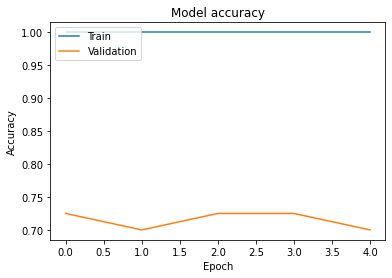

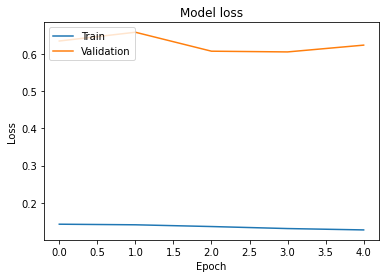

In [ ]:
# Plot training & validation ACC values

plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

# Plot training & validation loss values
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

In [ ]:
# Final evaluation of the model
scores = model.evaluate(X_test, yTest, verbose=0)
print("Accuracy: %.2f%%" % (scores[1]*100))

Accuracy: 70.00%


<b>Further Read:</b> https://missinglink.ai/guides/keras/keras-conv1d-working-1d-convolutional-neural-networks-keras/

---



<center><img width="500" height="300" src="https://drive.google.com/uc?id=1LdciBzE4Oc__NE00Bw0TisofYTP0qGc0"></center>